# 02_comparacion_resultados — Baselines A/D

**Objetivo:** consolidar y analizar resultados de los tres baselines (reglas, TF‑IDF, transformer).  
**Exportables:** `data/02_baselines_comparacion.csv` con métricas clave (macro F1/Prec/Rec, n).


In [1]:
# ===============================================================
# Setup: Imports y configuración de paths
# ===============================================================
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Importar utilidades compartidas
try:
    from utils_shared import setup_paths
    paths = setup_paths()
    DATA_PATH = paths['DATA_PATH']
    FIGS_PATH = paths['FIGS_PATH']
    print("✅ Usando utils_shared.py")
except ImportError:
    print("⚠️ No se encontró utils_shared.py, usando configuración manual")
    BASE_PATH = Path.cwd()
    if BASE_PATH.name == "notebooks":
        BASE_PATH = BASE_PATH.parent
    DATA_PATH = BASE_PATH / "data"
    FIGS_PATH = DATA_PATH / "figs"
    FIGS_PATH.mkdir(exist_ok=True)

print(f"📁 DATA_PATH: {DATA_PATH}")
print(f"📁 FIGS_PATH: {FIGS_PATH}")


✅ Usando utils_shared.py
📁 DATA_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data
📁 FIGS_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs


## 1) Cargar métricas y unificar

In [2]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path(DATA_PATH) if 'DATA_PATH' in globals() else Path('data')

paths = {
    "rule_based": {
        "eval": DATA_PATH/'rule_based_eval.csv',
        "report": DATA_PATH/'rule_based_classification_report.csv',
        "pred": DATA_PATH/'rule_based_predictions.csv',
    },
    "tfidf": {
        "eval": DATA_PATH/'tfidf_eval.csv',
        "report": DATA_PATH/'tfidf_classification_report.csv',
        "pred": DATA_PATH/'tfidf_predictions.csv',
    },
    "beto": {
        "eval": DATA_PATH/'beto_eval.csv',
        "report": DATA_PATH/'beto_classification_report.csv',
        "pred": DATA_PATH/'beto_predictions.csv',
    }
}

def pick(series, *names, default=None):
    """Devuelve el primer nombre presente en la serie."""
    for n in names:
        if n in series:
            return series[n]
    return default

rows = []
for name, ps in paths.items():
    if ps["eval"].exists():
        ev = pd.read_csv(ps["eval"]).iloc[0].to_dict()
        # Aceptar con o sin prefijo 'eval_'
        macro_f1       = pick(ev, "macro_f1", "eval_macro_f1")
        macro_prec     = pick(ev, "macro_precision", "eval_macro_precision")
        macro_rec      = pick(ev, "macro_recall", "eval_macro_recall")
        n_val          = pick(ev, "n")  # puede no existir en beto_eval
        if pd.isna(n_val) or n_val is None:
            # fallback: contar filas de predicciones si existe
            if ps.get("pred") and Path(ps["pred"]).exists():
                n_val = len(pd.read_csv(ps["pred"]))
        rows.append({"baseline": name,
                     "macro_f1": macro_f1,
                     "macro_precision": macro_prec,
                     "macro_recall": macro_rec,
                     "n": n_val})
    else:
        rows.append({"baseline": name, "macro_f1": None, "macro_precision": None, "macro_recall": None, "n": None})

comp = pd.DataFrame(rows, columns=["baseline","macro_f1","macro_precision","macro_recall","n"])
out_csv = DATA_PATH/'02_baselines_comparacion.csv'
comp.to_csv(out_csv, index=False, encoding='utf-8')
comp


,baseline,macro_f1,macro_precision,macro_recall,n
0,rule_based,0.518333,0.542575,0.527003,626.0
1,tfidf,0.902625,0.900794,0.904523,626.0
2,beto,0.883722,0.887585,0.880129,625.0


## 2) Visualización comparativa de métricas

✅ Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_metricas.png


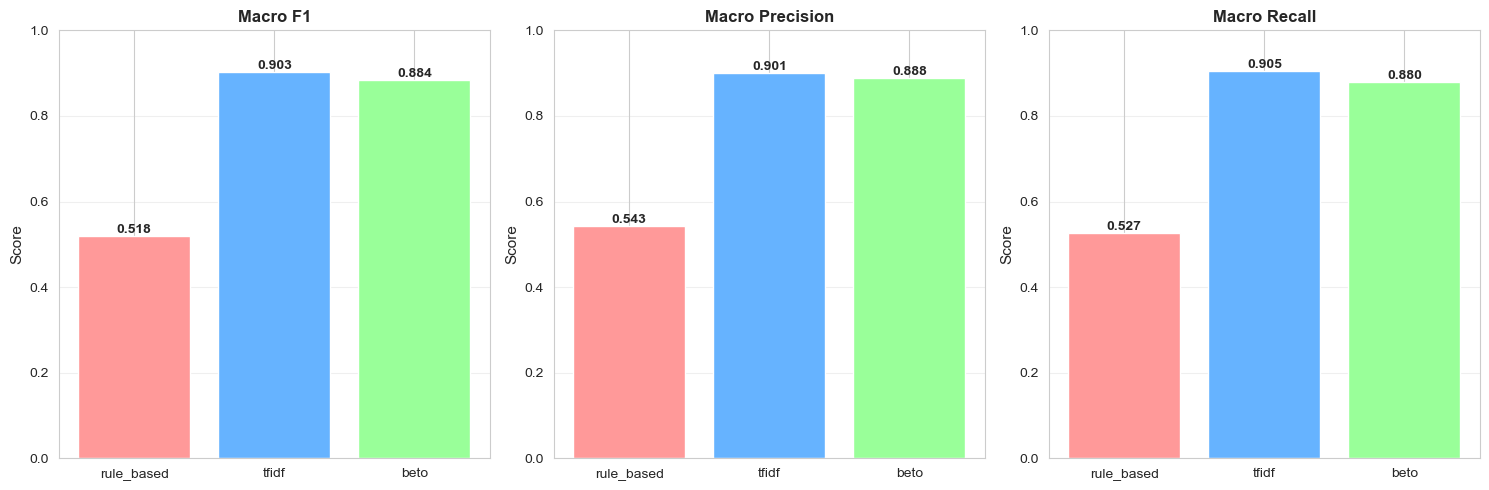


📊 Tabla resumen de resultados:


,baseline,macro_f1,macro_precision,macro_recall,n
0,rule_based,0.5183,0.5426,0.5270,626
1,tfidf,0.9026,0.9008,0.9045,626
2,beto,0.8837,0.8876,0.8801,625


In [3]:
# ===============================================================
# Gráfica de barras comparativa de métricas principales
# ===============================================================

# Filtrar solo baselines con métricas (no None)
comp_clean = comp[comp['macro_f1'].notna()].copy()

if len(comp_clean) == 0:
    print("⚠️ No hay métricas disponibles para visualizar.")
    print("   Ejecuta los 3 baselines primero.")
else:
    # Preparar datos para plotting
    metrics_to_plot = ['macro_f1', 'macro_precision', 'macro_recall']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        # Crear barplot
        bars = ax.bar(comp_clean['baseline'], comp_clean[metric], 
                      color=['#ff9999', '#66b3ff', '#99ff99'][:len(comp_clean)])
        
        # Añadir valores encima de las barras
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Configurar ejes
        ax.set_ylim(0, 1.0)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGS_PATH / '02_comparacion_metricas.png', dpi=150, bbox_inches='tight')
    print(f"✅ Gráfica guardada: {FIGS_PATH / '02_comparacion_metricas.png'}")
    plt.show()
    
    # Mostrar tabla resumen
    print("\n📊 Tabla resumen de resultados:")
    print("="*80)
    display(comp_clean.style.format({
        'macro_f1': '{:.4f}',
        'macro_precision': '{:.4f}',
        'macro_recall': '{:.4f}',
        'n': '{:.0f}'
    }).background_gradient(subset=['macro_f1', 'macro_precision', 'macro_recall'], 
                           cmap='RdYlGn', vmin=0, vmax=1))

## 3) Análisis por clase (Depresión vs Ansiedad)

✅ Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_por_clase.png


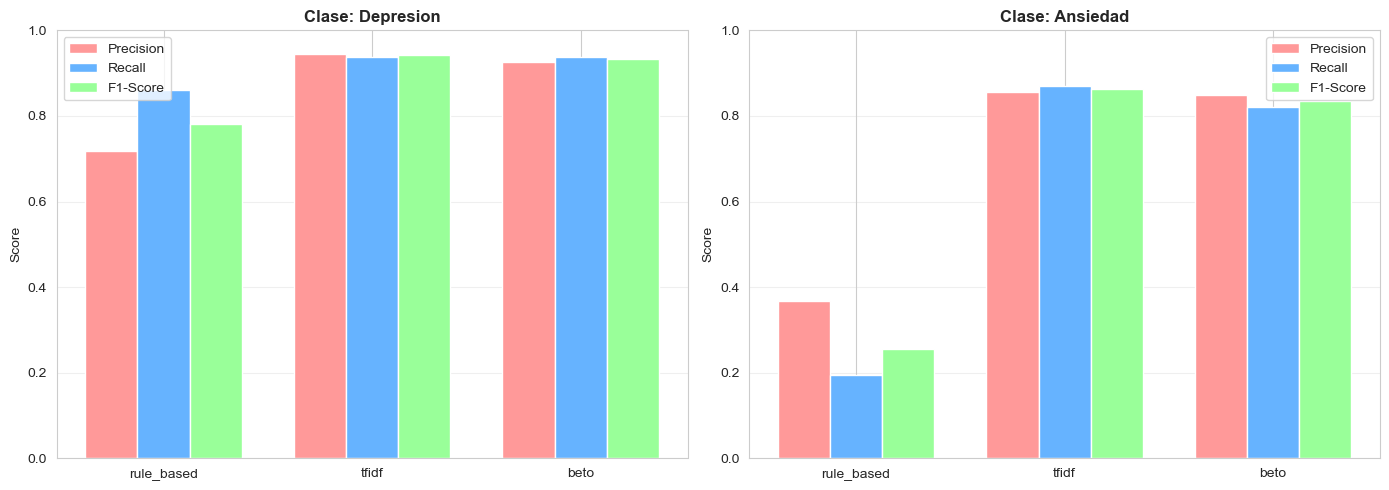


📊 Resultados detallados por clase:


clase,ansiedad,depresion
baseline,,
beto,0.8352,0.9323
rule_based,0.2544,0.7822
tfidf,0.8633,0.9420


In [4]:
# ===============================================================
# Comparar desempeño por clase usando classification reports
# ===============================================================

per_class_results = []

for name, ps in paths.items():
    if ps["report"].exists():
        report_df = pd.read_csv(ps["report"], index_col=0)
        
        # Extraer métricas por clase (depresion y ansiedad)
        for clase in ['depresion', 'ansiedad']:
            if clase in report_df.index:
                per_class_results.append({
                    'baseline': name,
                    'clase': clase,
                    'precision': report_df.loc[clase, 'precision'],
                    'recall': report_df.loc[clase, 'recall'],
                    'f1-score': report_df.loc[clase, 'f1-score']
                })

if per_class_results:
    df_per_class = pd.DataFrame(per_class_results)
    
    # Visualización por clase
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, clase in enumerate(['depresion', 'ansiedad']):
        ax = axes[idx]
        data_clase = df_per_class[df_per_class['clase'] == clase]
        
        if len(data_clase) > 0:
            x = np.arange(len(data_clase))
            width = 0.25
            
            # Barras para cada métrica
            ax.bar(x - width, data_clase['precision'], width, label='Precision', color='#ff9999')
            ax.bar(x, data_clase['recall'], width, label='Recall', color='#66b3ff')
            ax.bar(x + width, data_clase['f1-score'], width, label='F1-Score', color='#99ff99')
            
            ax.set_ylabel('Score')
            ax.set_title(f'Clase: {clase.capitalize()}', fontsize=12, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(data_clase['baseline'])
            ax.legend()
            ax.set_ylim(0, 1.0)
            ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGS_PATH / '02_comparacion_por_clase.png', dpi=150, bbox_inches='tight')
    print(f"✅ Gráfica guardada: {FIGS_PATH / '02_comparacion_por_clase.png'}")
    plt.show()
    
    # Tabla de resultados por clase
    print("\n📊 Resultados detallados por clase:")
    print("="*80)
    pivot_f1 = df_per_class.pivot(index='baseline', columns='clase', values='f1-score')
    display(pivot_f1.style.format('{:.4f}').background_gradient(cmap='RdYlGn', vmin=0, vmax=1))
else:
    print("⚠️ No hay reportes de clasificación disponibles.")

## 4) Interpretación de resultados y recomendaciones

### 📖 Guía de interpretación por baseline

**🔧 Rule-based (Patrones del fork colombiano)**
- **Fortalezas**: 
  - Completamente interpretable (trazabilidad de patrones)
  - No requiere entrenamiento
  - Útil para validar fenómenos lingüísticos específicos
- **Limitaciones**:
  - Sensible a typos y variantes ortográficas locales
  - Cobertura limitada por patrones predefinidos
  - Puede tener alta precisión pero bajo recall
- **Cuándo usarlo**: 
  - Para auditar señales lingüísticas específicas
  - Como baseline interpretable mínimo
  - Para identificar gaps en los patrones

**📊 TF-IDF + SVM (Char n-grams 3-5)**
- **Fortalezas**:
  - Robusto a errores ortográficos (char-level)
  - Rápido de entrenar
  - Buen balance precisión/recall en datasets ruidosos
- **Limitaciones**:
  - No captura semántica compleja
  - Requiere feature engineering (n-gramas)
  - Menos interpretable que reglas
- **Cuándo usarlo**:
  - Dataset con mucho ruido de transcripción
  - Necesidad de entrenamiento rápido
  - Cuando transformers son prohibitivos (tiempo/recursos)

**🤖 BETO (Transformer en español)**
- **Fortalezas**:
  - Captura contexto y semántica
  - Maneja negaciones y construcciones complejas
  - SOTA para español bien escrito
- **Limitaciones**:
  - Requiere datos suficientes (>500 ejemplos idealmente)
  - Más lento en inferencia
  - Sensible a ruido extremo (fuera de distribución del preentrenamiento)
- **Cuándo usarlo**:
  - Dataset grande y relativamente limpio
  - Necesidad de máximo desempeño
  - Cuando el tiempo de entrenamiento no es crítico

---

### 🎯 Recomendaciones basadas en resultados

**Si macro-F1 de rule-based es muy bajo (<0.3):**
- ✅ Los patrones colombianos no se ajustan bien al contexto paraguayo
- 💡 Considerar adaptar patrones locales usando EDA de n-gramas
- 💡 Revisar ejemplos de falsos negativos para expandir reglas

**Si TF-IDF supera significativamente a rule-based (+0.1 F1):**
- ✅ Confirma que el ruido ortográfico es un problema real
- 💡 El preprocesamiento agresivo ayuda
- 💡 Char n-grams capturan variantes que las reglas pierden

**Si BETO no mejora vs TF-IDF (<0.05 diferencia):**
- ⚠️ Posibles causas:
  1. Dataset muy pequeño (<200 ejemplos)
  2. Ruido extremo fuera de distribución de BERT
  3. Clases muy balanceadas haciendo que el problema sea "fácil"
- 💡 Considerar:
  - Data augmentation
  - Limpieza más agresiva
  - Ensembles (TF-IDF + BETO)

**Si BETO mejora significativamente (+0.1 F1 vs TF-IDF):**
- ✅ El contexto semántico es crucial
- ✅ Dataset tiene calidad suficiente
- 💡 Considerar fine-tuning más agresivo (más épocas)

---

### 📝 Próximos pasos sugeridos

1. **Análisis de errores**: Revisar predicciones incorrectas de cada modelo
2. **Ensemble**: Combinar predicciones (majority voting o stacking)
3. **Calibración**: Ajustar thresholds si una clase es más importante
4. **Datos**: Si F1 < 0.7, considerar:
   - Recolectar más datos
   - Limpiar etiquetas ruidosas
   - Balancear clases si hay desbalance extremo
5. **Despliegue**: Si F1 > 0.8, considerar prototipo para validación clínica